In [1]:
import sys

import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import platform
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import os

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


/var/folders/nc/qvnyyrpd0bs8ck8vt79yvt080000gn/T/ipykernel_3117/1727513233.py:12: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [2]:
#Load data
df = pd.read_csv('data_cleaned_R3.csv')
#df = df.iloc[:, :16]
df = df.dropna()
print(df.shape)
#print(df.columns)

(32768, 16)


In [3]:
print(df.shape[0])
nnnn= df.shape[0]
for cutoff in [13, 14, 15, 28,29,30] :
    print(f"cutoff = {cutoff}")
    print(df[df["Coal Input"]>cutoff].shape[0])
    print(100*df[df["Coal Input"]>cutoff].shape[0]/nnnn, "%")

32768
cutoff = 13
23002
70.196533203125 %
cutoff = 14
23001
70.1934814453125 %
cutoff = 15
22772
69.49462890625 %
cutoff = 28
22687
69.2352294921875 %
cutoff = 29
22686
69.232177734375 %
cutoff = 30
22564
68.85986328125 %


In [4]:
#Instead of dropping rows where plant is off, convert the row to zero

df.loc[df["Coal Input"] < 30] = 0
# df.loc[df['ATT 2 m_dot'] < 5] = 0

timeBackWindow, timeForwardWindow = 5, 2

In [5]:
# apply MinMaxScaler to the dataframe
# scaler = MinMaxScaler()
# scaled_df = scaler.fit_transform(df)

# #convert the numpy scaled array back to a dataframe
# df_scaled = pd.DataFrame(scaled_df, columns=df.columns)
df_scaled = df

In [6]:
#TODO Convert the hard code 8 to a stats term?
df_scaled['Power Plant On'] = (df_scaled['Coal Input'] >= 30).astype(int)

dataframes = []
indices = []
for index, row in df_scaled.iterrows():
    if row['Power Plant On'] == 0:
        if indices:
            dataframes.append(df_scaled.loc[indices].copy())
            indices = []
    else:
        indices.append(index)

# Check if there are any remaining indices after the loop ends
if indices:
    dataframes.append(df_scaled.loc[indices].copy())

# Print the number of different datasets and their lengths
print(f"Number of datasets: {len(dataframes)}")
#for i, dataset in enumerate(dataframes):
    #print(f"Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows
total_rows = sum(len(dataset) for dataset in dataframes)
print(f"Total number of rows: {total_rows}")


Number of datasets: 32
Total number of rows: 22565


In [7]:
def timewindow_df(df, timeBackWindow, timeForwardWindow):

    # Define column names for the first part
    cols_part1 = ['ECO SYS FW Supply SATN T', 'Economizer SYS FW Supply P', 'Live Steam TOT F',
                  'AMB Air T', 'Coal Input', 'BLR Primary Air F', 'BLR Secondary Air Total F',
                  'OVR FIR CORR Air NOZ 71-73 F', 'OVR FIR CORR Air NOZ 74-76 F',
                  'OVR FIR CORR Air NOZ 81-83 F', 'OVR FIR CORR Air NOZ 84-86 F']
    # Define column names for the second part
    cols_part2 = ['ATT 1 m_dot', 'ATT 2 m_dot', 'R/H ATT m_dot', 'HP Steam Average Temp', 'Hot R/H Average Temp']
    # Shift rows and concatenate for both parts
    df_temp = pd.DataFrame()

    for col in cols_part1 + cols_part2:
        # Shift columns forward for the first part
        if col in cols_part1:
            df_new = pd.concat([df[col].shift(-i) for i in range(timeBackWindow-1, -1, -1)], axis=1, 
                               keys=[f'{col}-{i}' for i in range(timeBackWindow)])
        # Shift columns backward for the second part
        else:
            shifted_cols = [df[col].shift(i) for i in range(timeForwardWindow)]
            df_new = pd.concat(shifted_cols, axis=1, 
                               keys=[f'{col}+{i}' for i in range(timeForwardWindow)])
        # Concatenate the resulting dataframe with df_temp, along the columns axis (axis=1)
        df_temp = pd.concat([df_temp, df_new], axis=1)

    return df_temp


In [9]:
#Time window the datasets
manipulated_dataframes = []

for df in dataframes:
    manipulated_df = timewindow_df(df,timeBackWindow=timeBackWindow,timeForwardWindow=timeForwardWindow)
    manipulated_dataframes.append(manipulated_df)


# Print the number of rows for each dataset in the manipulated dataframes
print(f"Number of manipulated datasets: {len(manipulated_dataframes)}")
#for i, dataset in enumerate(manipulated_dataframes):
    #print(f"Manipulated Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows across all the manipulated datasets
total_rows = sum(len(dataset) for dataset in manipulated_dataframes)

# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Number of manipulated datasets: 32
Total number of rows: 22565


In [10]:
# Remove rows with NaN values from each dataframe
manipulated_dataframes_cleaned = []
for dataset in manipulated_dataframes:
    cleaned_dataset = dataset.dropna()
    manipulated_dataframes_cleaned.append(cleaned_dataset)

# Print the number of rows for each dataset in the cleaned manipulated dataframes
print(f"Number of manipulated datasets: {len(manipulated_dataframes_cleaned)}")
#for i, dataset in enumerate(manipulated_dataframes_cleaned):
    #print(f"Manipulated Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows across all the cleaned manipulated datasets
total_rows = sum(len(dataset) for dataset in manipulated_dataframes_cleaned)

# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Number of manipulated datasets: 32
Total number of rows: 22412


In [11]:
# Concat datasets
processed_df = pd.concat(manipulated_dataframes_cleaned, ignore_index=True)

In [12]:
#Remove rows that contain zeros
# Count the initial number of rows
initial_row_count = len(processed_df)

# Remove rows containing zeros
processed_df = processed_df[(processed_df != 0).all(axis=1)]

# Count the number of rows removed
rows_removed = initial_row_count - len(processed_df)

# Count the number of rows remaining
rows_remaining = len(processed_df)

print(f"Rows removed: {rows_removed}")
print(f"Rows remaining: {rows_remaining}")

Rows removed: 61
Rows remaining: 22351


In [13]:
processed_df.head()
temp_df = processed_df.copy()

In [14]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df)

# Convert the scaled data back to a DataFrame
processed_df = pd.DataFrame(scaled_df, columns=processed_df.columns)

In [15]:
processed_df.head()

,ECO SYS FW Supply SATN T-0,ECO SYS FW Supply SATN T-1,ECO SYS FW Supply SATN T-2,ECO SYS FW Supply SATN T-3,ECO SYS FW Supply SATN T-4,Economizer SYS FW Supply P-0,Economizer SYS FW Supply P-1,Economizer SYS FW Supply P-2,Economizer SYS FW Supply P-3,Economizer SYS FW Supply P-4,...,ATT 1 m_dot+0,ATT 1 m_dot+1,ATT 2 m_dot+0,ATT 2 m_dot+1,R/H ATT m_dot+0,R/H ATT m_dot+1,HP Steam Average Temp+0,HP Steam Average Temp+1,Hot R/H Average Temp+0,Hot R/H Average Temp+1
0,0.164348,0.146047,0.138909,0.106881,0.115300,0.076706,0.067118,0.063734,0.045789,0.050876,...,0.026628,0.232270,0.128191,0.192987,0.376368,0.272241,0.373611,0.290906,0.053626,0.075214
1,0.157394,0.164348,0.146047,0.138909,0.106881,0.070502,0.076706,0.067118,0.061617,0.045789,...,0.131558,0.026628,0.205891,0.128191,0.368831,0.376519,0.480620,0.373611,0.162523,0.117737
2,0.157394,0.157394,0.164348,0.146047,0.138909,0.075014,0.070502,0.076706,0.065008,0.061617,...,0.189560,0.131558,0.198036,0.205891,0.430829,0.368984,0.560445,0.480620,0.266009,0.219257
3,0.173316,0.157394,0.157394,0.164348,0.146047,0.081218,0.075014,0.070502,0.074618,0.065008,...,0.449512,0.189560,0.174755,0.198036,0.398006,0.430967,0.654495,0.560445,0.375796,0.315732
4,0.164348,0.173316,0.157394,0.157394,0.164348,0.078962,0.081218,0.075014,0.068400,0.074618,...,0.105721,0.449512,0.038990,0.174755,0.290785,0.398153,0.722398,0.654495,0.480994,0.418082


In [16]:

x_cols = timeBackWindow * 11  # Adjust this 11 to be the number of columns in the x part of the dataset
x_data = processed_df.iloc[:, :x_cols].values
y_data = processed_df.iloc[:, x_cols:].values

#Test/Train Split
train_perc = 0.9

print("True")
print(x_data.shape)
print(y_data.shape)

print("Adapated")
x_train = x_data[:int(train_perc*x_data.shape[0]),:]
x_test = x_data[int(train_perc*x_data.shape[0]):,:]

y_train = y_data[:int(train_perc*y_data.shape[0]),:]
y_test = y_data[int(train_perc*y_data.shape[0]):,:]

#Summarize the shapes of the train and test sets
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

True
(22351, 55)
(22351, 10)
Adapated
(20115, 55)
(2236, 55)
(2236, 10)
(20115, 10)


In [24]:
class ANN(keras.Model):
    def __init__(self):
        super(ANN, self).__init__()
        self.input_layer = keras.layers.Dense(units=64, input_shape=(x_train.shape[0],), activation='relu')
        self.hidden_layers = [keras.layers.Dense(units=128, activation='relu'),
                              keras.layers.Dense(units=128, activation='relu')]
        self.output_layer = keras.layers.Dense(units=10, activation='linear')

    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

model = ANN()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

# Build the model before training
model.build((None, 55))

# Define EarlyStopping callback
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Define the different configurations
configurations = [
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2}
]


In [33]:

#hist = model.fit(x_train, y_train, epochs=500, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
hist = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.2)


Epoch 1/500
503/503 [==============================] - 3s 6ms/step - loss: 0.0078 - mean_absolute_percentage_error: 19038.3770 - root_mean_squared_error: 0.0884 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 19.4613 - val_root_mean_squared_error: 0.1298
Epoch 2/500
503/503 [==============================] - 3s 6ms/step - loss: 0.0077 - mean_absolute_percentage_error: 13748.9121 - root_mean_squared_error: 0.0879 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 19.3817 - val_root_mean_squared_error: 0.1246
Epoch 3/500
503/503 [==============================] - 3s 6ms/step - loss: 0.0077 - mean_absolute_percentage_error: 14232.1846 - root_mean_squared_error: 0.0877 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 20.0009 - val_root_mean_squared_error: 0.1282
Epoch 4/500
503/503 [==============================] - 3s 6ms/step - loss: 0.0076 - mean_absolute_percentage_error: 15630.2734 - root_mean_squared_error: 0.0873 - val_loss: 0.0157 - val_mean_absolute_percenta

KeyboardInterrupt: 

In [27]:
loss, MAPE, RMSE = model.evaluate(x_test, y_test)
forecast = model.predict(x_test)

70/70 [==============================] - 0s 1ms/step


2023-06-01 20:49:14.324373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [31]:
#Add blank columns to forecast to match the shape
blank_array = np.empty((2236, 55))
forecast_shape = np.concatenate((blank_array, forecast), axis=1)
pred_original_scaled = scaler.inverse_transform(forecast_shape)

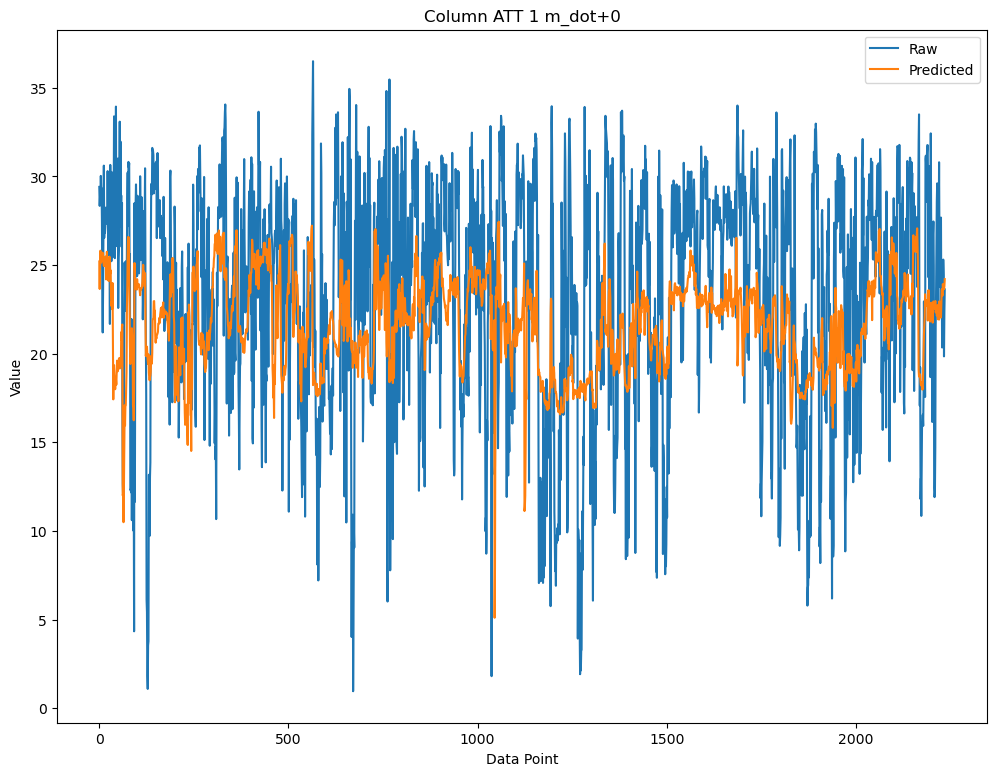

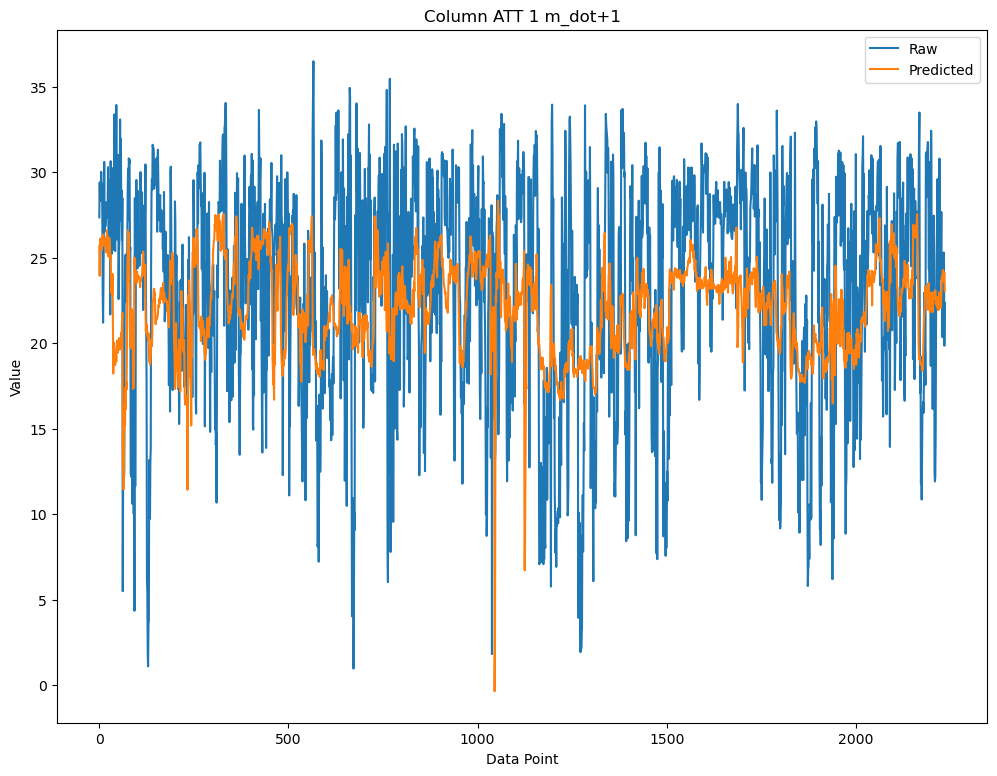

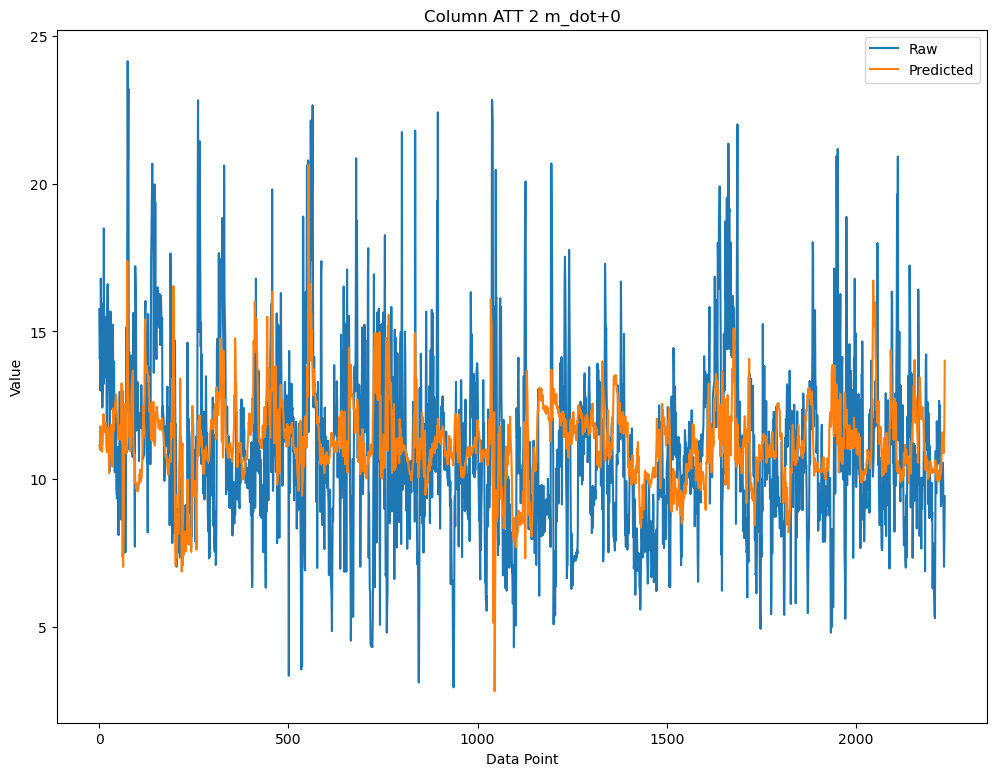

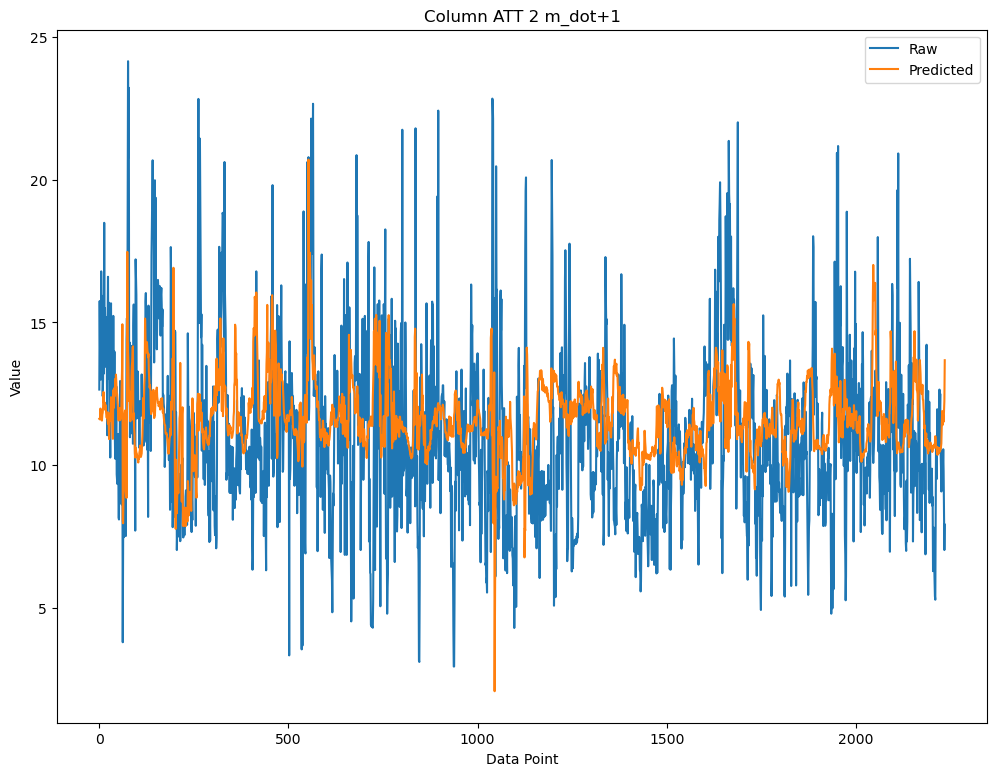

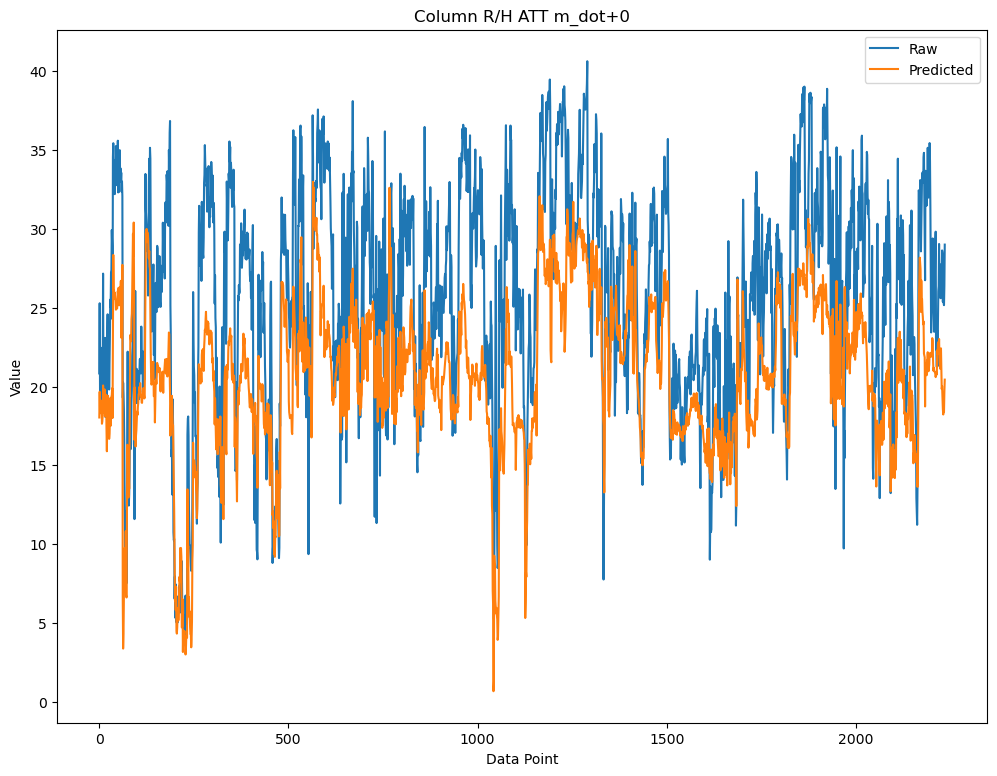

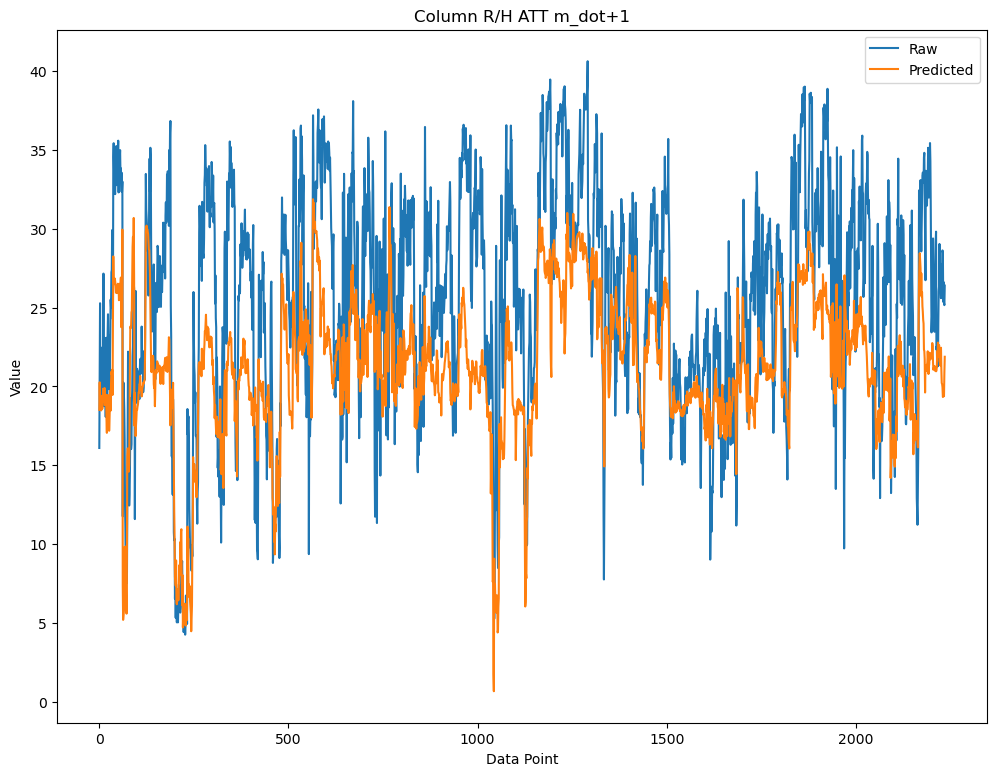

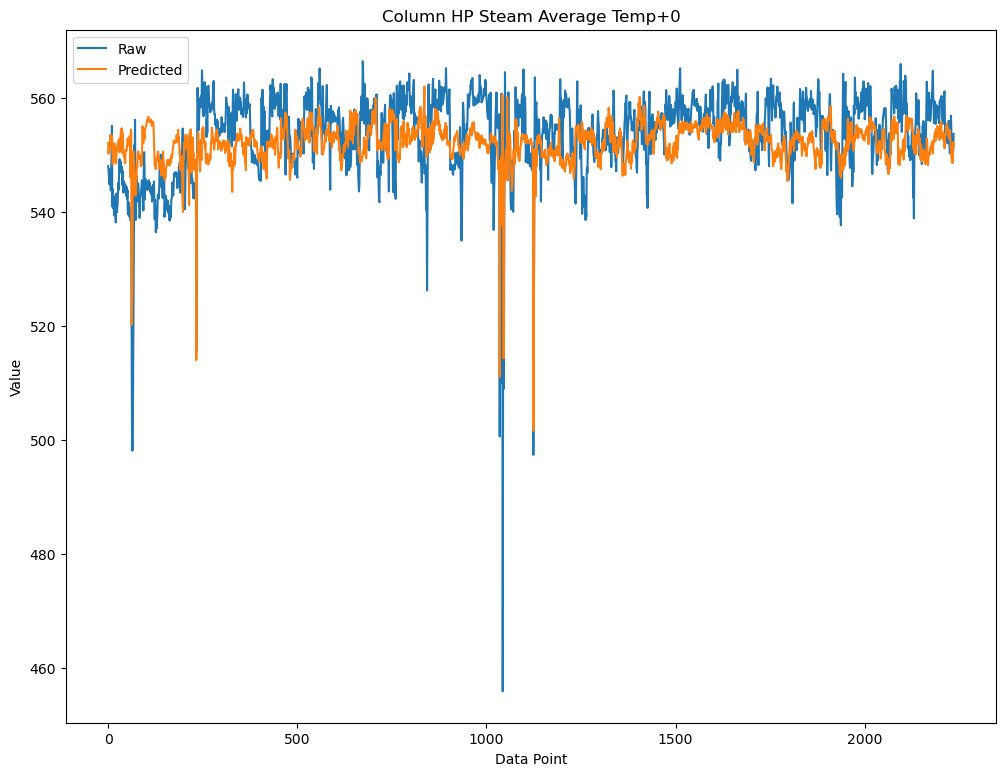

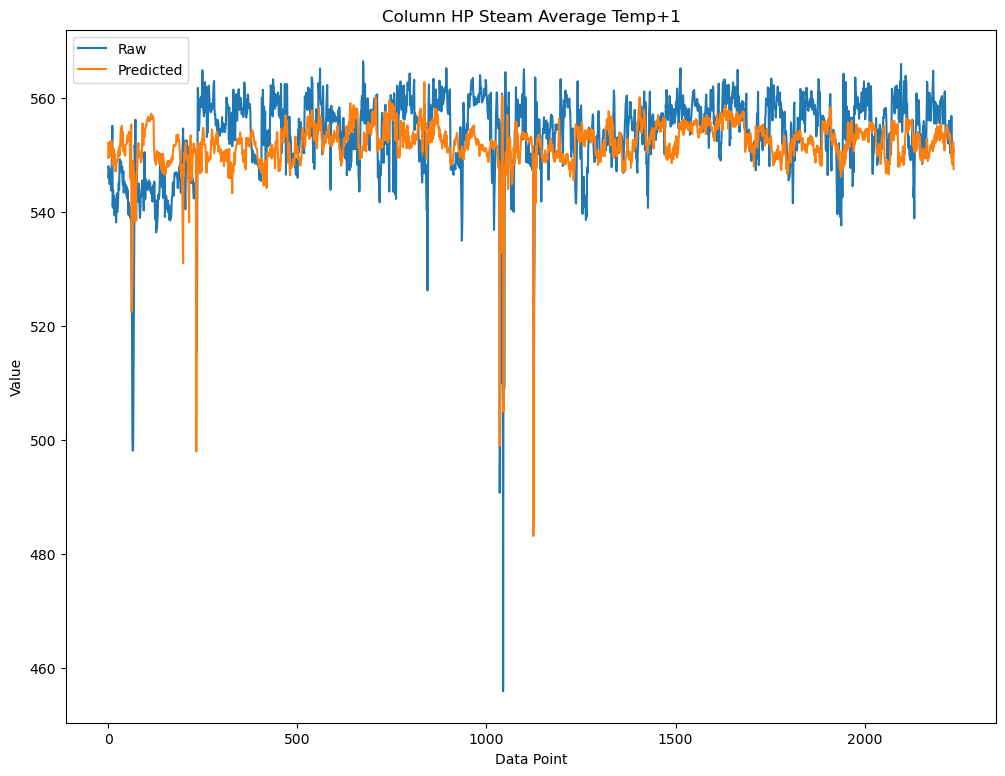

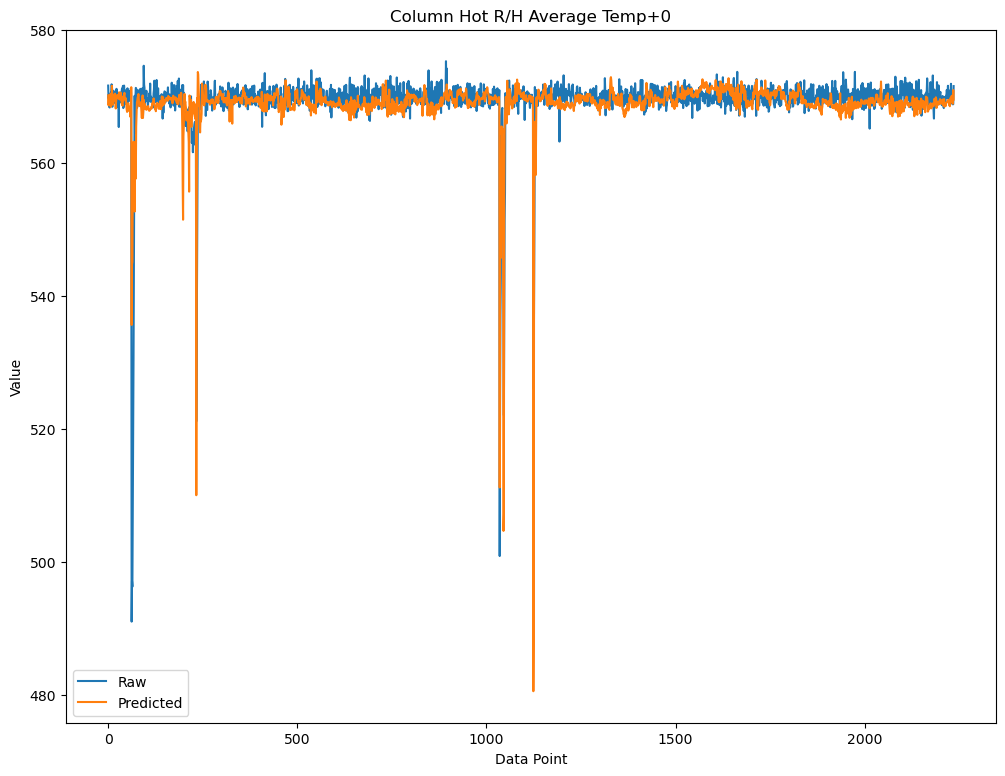

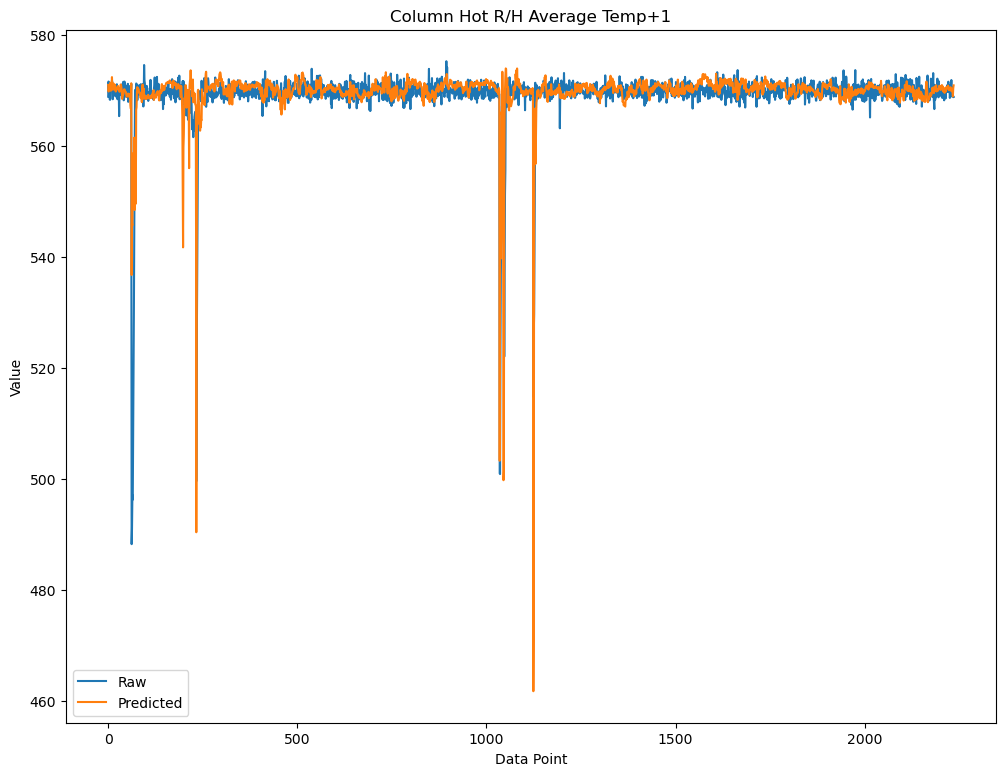

In [32]:
#headings
col_headings = ["ATT 1 m_dot+0","ATT 1 m_dot+1","ATT 2 m_dot+0","ATT 2 m_dot+1","R/H ATT m_dot+0","R/H ATT m_dot+1","HP Steam Average Temp+0","HP Steam Average Temp+1","Hot R/H Average Temp+0","Hot R/H Average Temp+1"]
for col in range(55,65):
    column_pred = pred_original_scaled[:, col]  # Assuming column 56 corresponds to index 55
    column_temp_last_2236 = temp_df.iloc[-2236:, col].values  # Extract last 2236 entries of column 56

    # Create the plot
    plt.figure(figsize=(12, 9))
    plt.plot(column_temp_last_2236, label='Raw')
    plt.plot(column_pred, label='Predicted')

    # Add labels and legend
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f"Column {col_headings[col-55]}")
    # Show the plot
    plt.show()

In [ ]:
# Plot the training loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], color="red")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the training metrics
plt.plot(hist.history['mean_absolute_percentage_error'])
plt.plot(hist.history['val_mean_absolute_percentage_error'], color="red")
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.show()

# Plot the MAPE without training MAPE
plt.plot(hist.history['val_mean_absolute_percentage_error'], color="red")
plt.title('Validation Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.show()

# Plot the training metrics
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'], color="red")
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()


In [23]:
configurations = [
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 128, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 2, 'neurons': 256, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 128, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 32, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 64, 'validation_split': 0.2},
    {'hidden_layers': 3, 'neurons': 256, 'epochs': 500, 'batch_size': 128, 'validation_split': 0.2}
]

hist = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.2)
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()


# Extract the training and validation metrics from the history object
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

# Save the metrics and evaluation results to the results DataFrame
results_df[f'Configuration {1} Training Loss'] = training_loss
results_df[f'Configuration {1} Validation Loss'] = validation_loss
results_df[f'Configuration {1} Training Accuracy'] = training_accuracy
results_df[f'Configuration {1} Validation Accuracy'] = validation_accuracy
results_df.loc[:, f'Configuration {1} Loss'] = loss
results_df.loc[:, f'Configuration {1} MAPE'] = MAPE
results_df.loc[:, f'Configuration {1} RMSE'] = RMSE

# Save the predictions to a separate DataFrame
forecast_df = pd.DataFrame(forecast, columns=['Prediction'])
forecast_df.to_excel(f'forecast_configuration_{1}.xlsx', index=False)


# Plot the training and validation loss for each configuration#headings
col_headings = ["ATT 1 m_dot+0","ATT 1 m_dot+1","ATT 2 m_dot+0","ATT 2 m_dot+1","R/H ATT m_dot+0","R/H ATT m_dot+1","HP Steam Average Temp+0","HP Steam Average Temp+1","Hot R/H Average Temp+0","Hot R/H Average Temp+1"]


# Create a folder to save the plots
folder_name = 'plots'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

#Add blank columns to forecast to match the shape
blank_array = np.empty((2236, 55))
forecast_shape = np.concatenate((blank_array, forecast), axis=1)
pred_original_scaled = scaler.inverse_transform(forecast_shape)

for col in range(55,65):
    column_pred = pred_original_scaled[:, col]  # Assuming column 56 corresponds to index 55
    column_temp_last_2236 = temp_df.iloc[-2236:, col].values  # Extract last 2236 entries of column 56

# Create the plot
plt.figure(figsize=(12, 9))
plt.plot(column_temp_last_2236, label='Raw')
plt.plot(column_pred, label='Predicted')

# Add labels and legend
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.title(f"Column {col_headings[col-55]}")

# Save the plot to the folder
plot_filename = os.path.join(folder_name, f"plot_Configuration{i}_{col-55}.png")
plt.savefig(plot_filename)
plt.close()  # Close the figure to free up memory


# Save the results DataFrame to an Excel file
results_df.to_excel('model_results.xlsx', index=False)

Epoch 1/500


ValueError: in user code:

    File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/nc/qvnyyrpd0bs8ck8vt79yvt080000gn/T/__autograph_generated_file7pjzp_bg.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).input_layer, (ag__.ld(inputs),), None, fscope)

    ValueError: Exception encountered when calling layer "ann_8" (type ANN).
    
    in user code:
    
        File "/var/folders/nc/qvnyyrpd0bs8ck8vt79yvt080000gn/T/ipykernel_3117/235340267.py", line 11, in call  *
            x = self.input_layer(inputs)
        File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "dense_37" is incompatible with the layer: expected axis -1 of input shape to have value 50, but received input with shape (None, 55)
    
    
    Call arguments received by layer "ann_8" (type ANN):
      • inputs=tf.Tensor(shape=(None, 55), dtype=float32)
